In [1]:
import sys
sys.path.append("..") # go to parent dir

In [2]:
from src.piomhmm import mHMM

import numpy as np
import matplotlib.pyplot as plt
import torch

import warnings
warnings.filterwarnings('ignore')

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=2)

## Generate Data

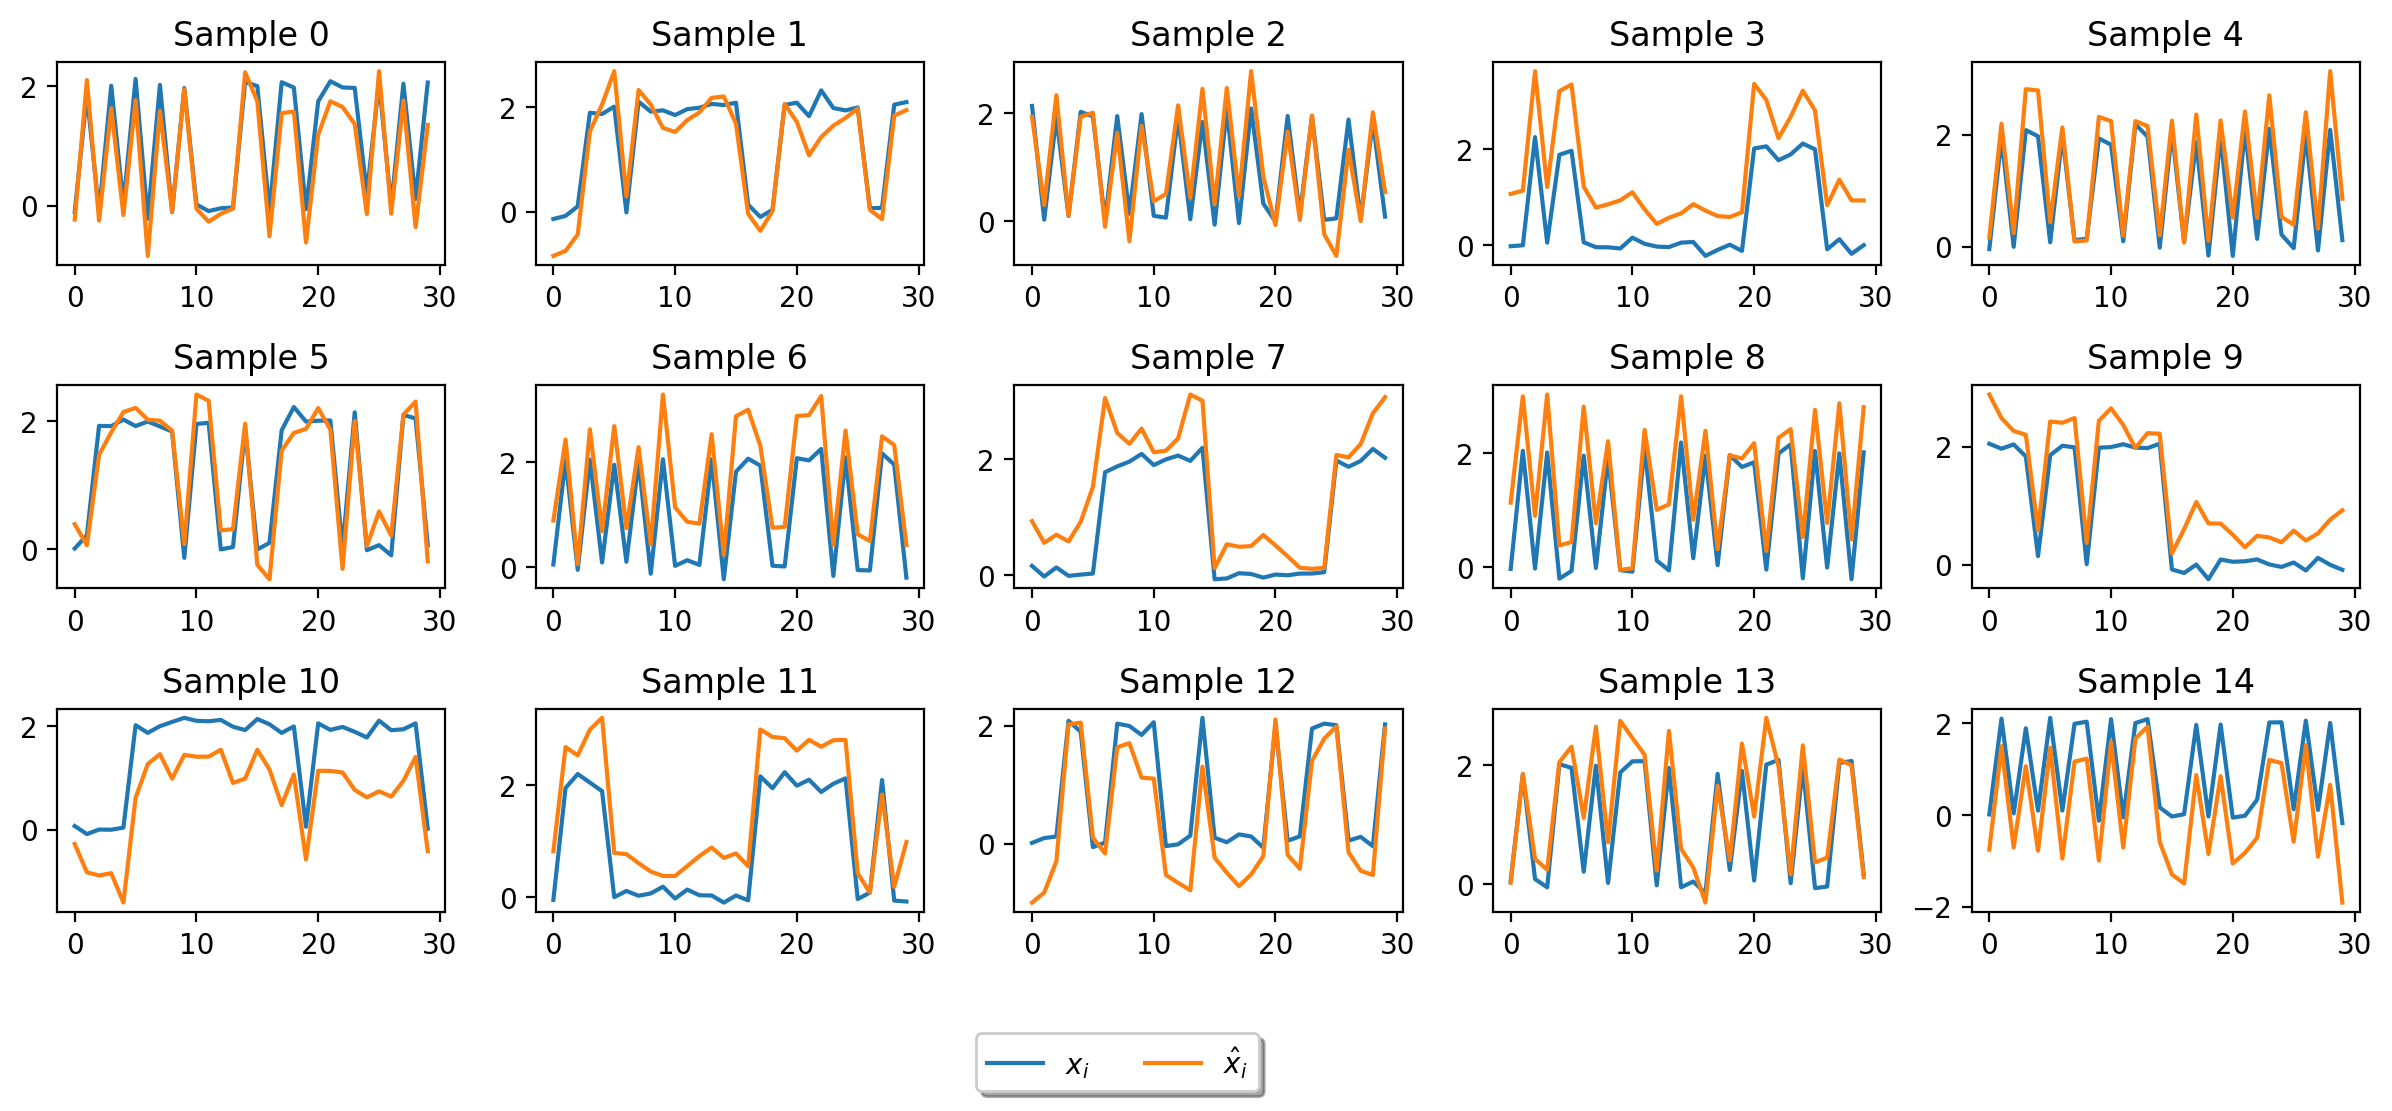

In [3]:
torch.manual_seed(0)


n = 200 #number of samples
d = 1 #dimensionality of observations
t = 30 #number of time steps
k = 2 #number of states
K = 2 #number of HMM mixtures

A_1 = torch.tensor([[0.8, 0.2],[0.2, 0.8]]) #transition matrix
A_2 = torch.tensor([[0.2, 0.8],[0.8, 0.2]]) #transition matrix
A = torch.block_diag(*[A_1, A_2])
pi = torch.ones(k*K)/(k*K) #initial state distribution
mu = torch.tensor([0., 2., 0., 2.]) # state means
var = torch.tensor([0.1, 0.1, 0.1, 0.1]) #state covariance
b = 1.0 #specify the range of a uniform distribution over personalized state effects, e.g. r_i ~ Unif[-b, b]

X = torch.zeros((n,t,d))
Z = torch.zeros((n,t), dtype=torch.long)

for i in range(n):
    for j in range(t):
        if j == 0:
            Z[i, j] = torch.multinomial(pi, num_samples=1).byte()
            # D[i, j] = torch.rand(1)
            m_dist = torch.distributions.normal.Normal(
                mu.index_select(0, Z[i, j]),
                var.index_select(0, Z[i, j]))
            X[i, j, :] = m_dist.sample()
        else:
            Z[i, j] = torch.multinomial(A[Z[i, j - 1], :], num_samples=1)
            # D[i, j] = torch.rand(1)
            m_dist = torch.distributions.normal.Normal(
                mu.index_select(0, Z[i, j]),
                var.index_select(0, Z[i, j]))
            X[i, j, :] = m_dist.sample()


X_hat = torch.zeros(n, t, d)

l = 1.0 #lengthscale for the SE kernel
s = 0.1 #sigma^2 for the SE kernel

#build covariance matrix
var_x = torch.zeros(t,t)
t_vec = torch.range(0,t)
for j in range(t):
    for jj in range(t):
        r = (t_vec[j] - t_vec[jj])**2
        var_x[j, jj] = s*torch.exp(-r/(2*(l**2)))

L = torch.cholesky(var_x)
b_stor = torch.zeros(n)

for i in range(n):
    e = torch.randn(t)
    b_stor[i] = 2*b*torch.rand(1) - b
    X_hat[i, :, :] =  torch.einsum('ik,k->i', [L, e])[None, :, None] + X[i, :, :] + b_stor[i]*torch.ones(1,t,1)
    
    
fig, axs = plt.subplots(3,5,dpi=200)
fig.set_size_inches(12,5)
for i, ax in enumerate(axs.flatten()):
    ax.plot(X[i, :].numpy(), label='$x_i$')
    
    ax.plot(X_hat[i, :].numpy(), label='$\hat{x}_i$')
        
    ax.set_title('Sample ' + str(i))
fig.tight_layout()  
ax.legend(loc='lower center', bbox_to_anchor=(-2.2, -0.95),
          fancybox=True, shadow=True, ncol=5)
    

## Fit Models 

In [4]:
device = "cpu"

print("fitting standard HMM...")
hmm = mHMM(X_hat, k=2, K=1, full_cov=True, io=False, personalized=False, 
          personalized_io=False, state_io=False, device=device, eps=1e-18)    
hmm_params, _, ll_hmm = hmm.learn_model(num_iter=10000, intermediate_save=False)

print("fitting standard mHMM...")
mhmm = mHMM(X_hat, k=2, K=2, full_cov=True, io=False, personalized=False, 
            personalized_io=False, state_io=False, device=device, eps=1e-18)
mhmm_params, _, ll_mhmm = mhmm.learn_model(num_iter=10000, intermediate_save=False)

fitting standard HMM...
Iteration  0
Iteration  500
Iteration  1000
Iteration  1500
Iteration  2000
Iteration  2500
Iteration  3000
Iteration  3500
Iteration  4000
Iteration  4500
Iteration  5000
Iteration  5500
Iteration  6000
Iteration  6500
Iteration  7000
Iteration  7500
Iteration  8000
Iteration  8500
Iteration  9000
Iteration  9500
fitting standard mHMM...
Iteration  0
Iteration  500
Iteration  1000
Iteration  1500
Iteration  2000
Iteration  2500
Iteration  3000
Iteration  3500
Iteration  4000
Iteration  4500
Iteration  5000
Iteration  5500
Iteration  6000
Iteration  6500
Iteration  7000
Iteration  7500
Iteration  8000
Iteration  8500
Iteration  9000
Iteration  9500


In [5]:
print("fitting personalized HMM...")
phmm = mHMM(X_hat, k=2, K=1, full_cov=True, io=False, personalized=True, personalized_io=False,
           state_io=False, device=device, eps=1e-18)
phmm_params, _, _, elbo_phmm, b_hat_phmm, _  = phmm.learn_model(num_iter=10000, intermediate_save=False)

print("fitting personalized mHMM...")
mphmm = mHMM(X_hat, k=2, K=2, full_cov=True, io=False, personalized=True, personalized_io=False,
             state_io=False, device=device, eps=1e-18)
mphmm_params, _, _, elbo_mphmm, b_hat_mphmm, _  = mphmm.learn_model(num_iter=10000, intermediate_save=False)

fitting personalized HMM...
Iteration  0
Iteration  500
Iteration  1000
Iteration  1500
Iteration  2000
Iteration  2500
Iteration  3000
Iteration  3500
Iteration  4000
Iteration  4500
Iteration  5000
Iteration  5500
Iteration  6000
Iteration  6500
Iteration  7000
Iteration  7500
Iteration  8000
Iteration  8500
Iteration  9000
Iteration  9500
fitting personalized mHMM...
Iteration  0
Iteration  500
Iteration  1000
Iteration  1500
Iteration  2000
Iteration  2500
Iteration  3000
Iteration  3500
Iteration  4000
Iteration  4500
Iteration  5000
Iteration  5500
Iteration  6000
Iteration  6500
Iteration  7000
Iteration  7500
Iteration  8000
Iteration  8500
Iteration  9000
Iteration  9500


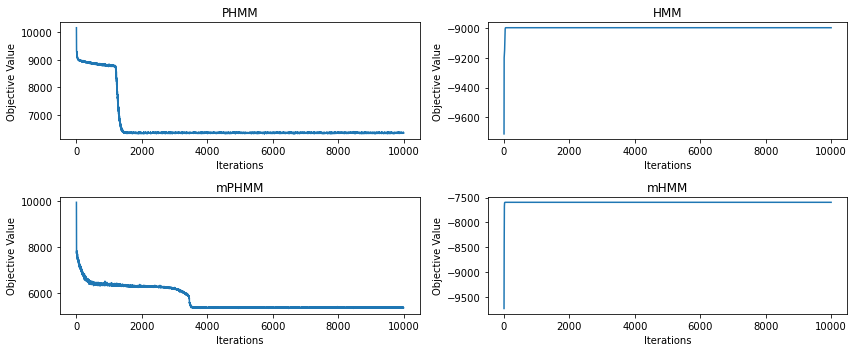

In [13]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(12,5)

outputs = {(0,0):{"model_name":"PHMM", "loss":elbo_phmm}, 
           (0,1):{"model_name":"HMM", "loss":ll_hmm}, 
           (1,0):{"model_name":"mPHMM", "loss":elbo_mphmm}, 
           (1,1):{"model_name":"mHMM", "loss":ll_mhmm}}

for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        if outputs[(i,j)]:
            ax.plot(outputs[(i,j)]["loss"])
            ax.set_xlabel('Iterations')
            ax.set_ylabel('Objective Value')
            ax.set_title(outputs[(i,j)]["model_name"])

fig.tight_layout()

In [14]:
A, mu, var

(tensor([[0.80, 0.20, 0.00, 0.00],
         [0.20, 0.80, 0.00, 0.00],
         [0.00, 0.00, 0.20, 0.80],
         [0.00, 0.00, 0.80, 0.20]]),
 tensor([0., 2., 0., 2.]),
 tensor([0.10, 0.10, 0.10, 0.10]))

In [15]:
hmm_params["A"], mhmm_params["A"], phmm_params["A"] , mphmm_params["A"]

(tensor([[0.97, 0.03],
         [0.02, 0.98]]),
 tensor([[0.48, 0.50, 0.00, 0.00],
         [0.48, 0.52, 0.00, 0.00],
         [0.00, 0.00, 0.56, 0.42],
         [0.00, 0.00, 0.41, 0.58]]),
 tensor([[0.55, 0.45],
         [0.47, 0.53]]),
 tensor([[0.20, 0.80, 0.00, 0.00],
         [0.79, 0.21, 0.00, 0.00],
         [0.00, 0.00, 0.81, 0.19],
         [0.00, 0.00, 0.20, 0.80]]))

In [16]:
hmm_params["mu"], mhmm_params["mu"] , phmm_params["mu"], mphmm_params["mu"]

(tensor([[0.33],
         [1.64]]),
 tensor([[ 0.55],
         [ 2.57],
         [ 1.56],
         [-0.44]]),
 tensor([[2.06],
         [0.06]]),
 tensor([[ 0.18],
         [ 2.19],
         [ 1.97],
         [-0.03]]))

In [17]:
hmm_params["var"], mhmm_params["var"], phmm_params["var"], mphmm_params["var"]

(tensor([[[1.00]],
 
         [[1.06]]]),
 tensor([[[0.15]],
 
         [[0.18]],
 
         [[0.16]],
 
         [[0.21]]]),
 tensor([[[0.11]],
 
         [[0.10]]]),
 tensor([[[0.10]],
 
         [[0.10]],
 
         [[0.11]],
 
         [[0.10]]]))

In [18]:
def pred(model_name, model, params, b_hat):
    model_mps = model.predict_sequence(params, n_sample=b_hat)
        
    xhat = np.zeros((n,t))
    xvar = np.zeros((n,t))

    for i in range(n):
        for j in range(t):
            idx = np.where(model_mps[i,j].numpy() == np.arange(model.k))[0][0]        
            if model_name in ["HMM", "mHMM"]:
                xhat[i,j] = params['mu'][idx].numpy()                
            else:
                xhat[i,j] = params['mu'][idx].numpy() + b_hat[i].detach().numpy()
            xvar[i,j] = 2*np.sqrt(params['var'][idx].numpy())     
        
    return {"xhat":xhat, "xvar":xvar}

outputs = {"HMM":{"model":hmm, "params":hmm_params, "b_hat":None},
           "mHMM":{"model":mhmm, "params":mhmm_params, "b_hat":None},
           "PHMM":{"model":phmm, "params":phmm_params, "b_hat":b_hat_phmm},
           "mPHMM":{"model":mphmm, "params":mphmm_params, "b_hat":b_hat_mphmm}
          }
preds = {}
for model_name in outputs:
    model = outputs[model_name]["model"]
    params = outputs[model_name]["params"]
    b_hat = outputs[model_name]["b_hat"]
    
    preds[model_name] = pred(model_name, model, params, b_hat)

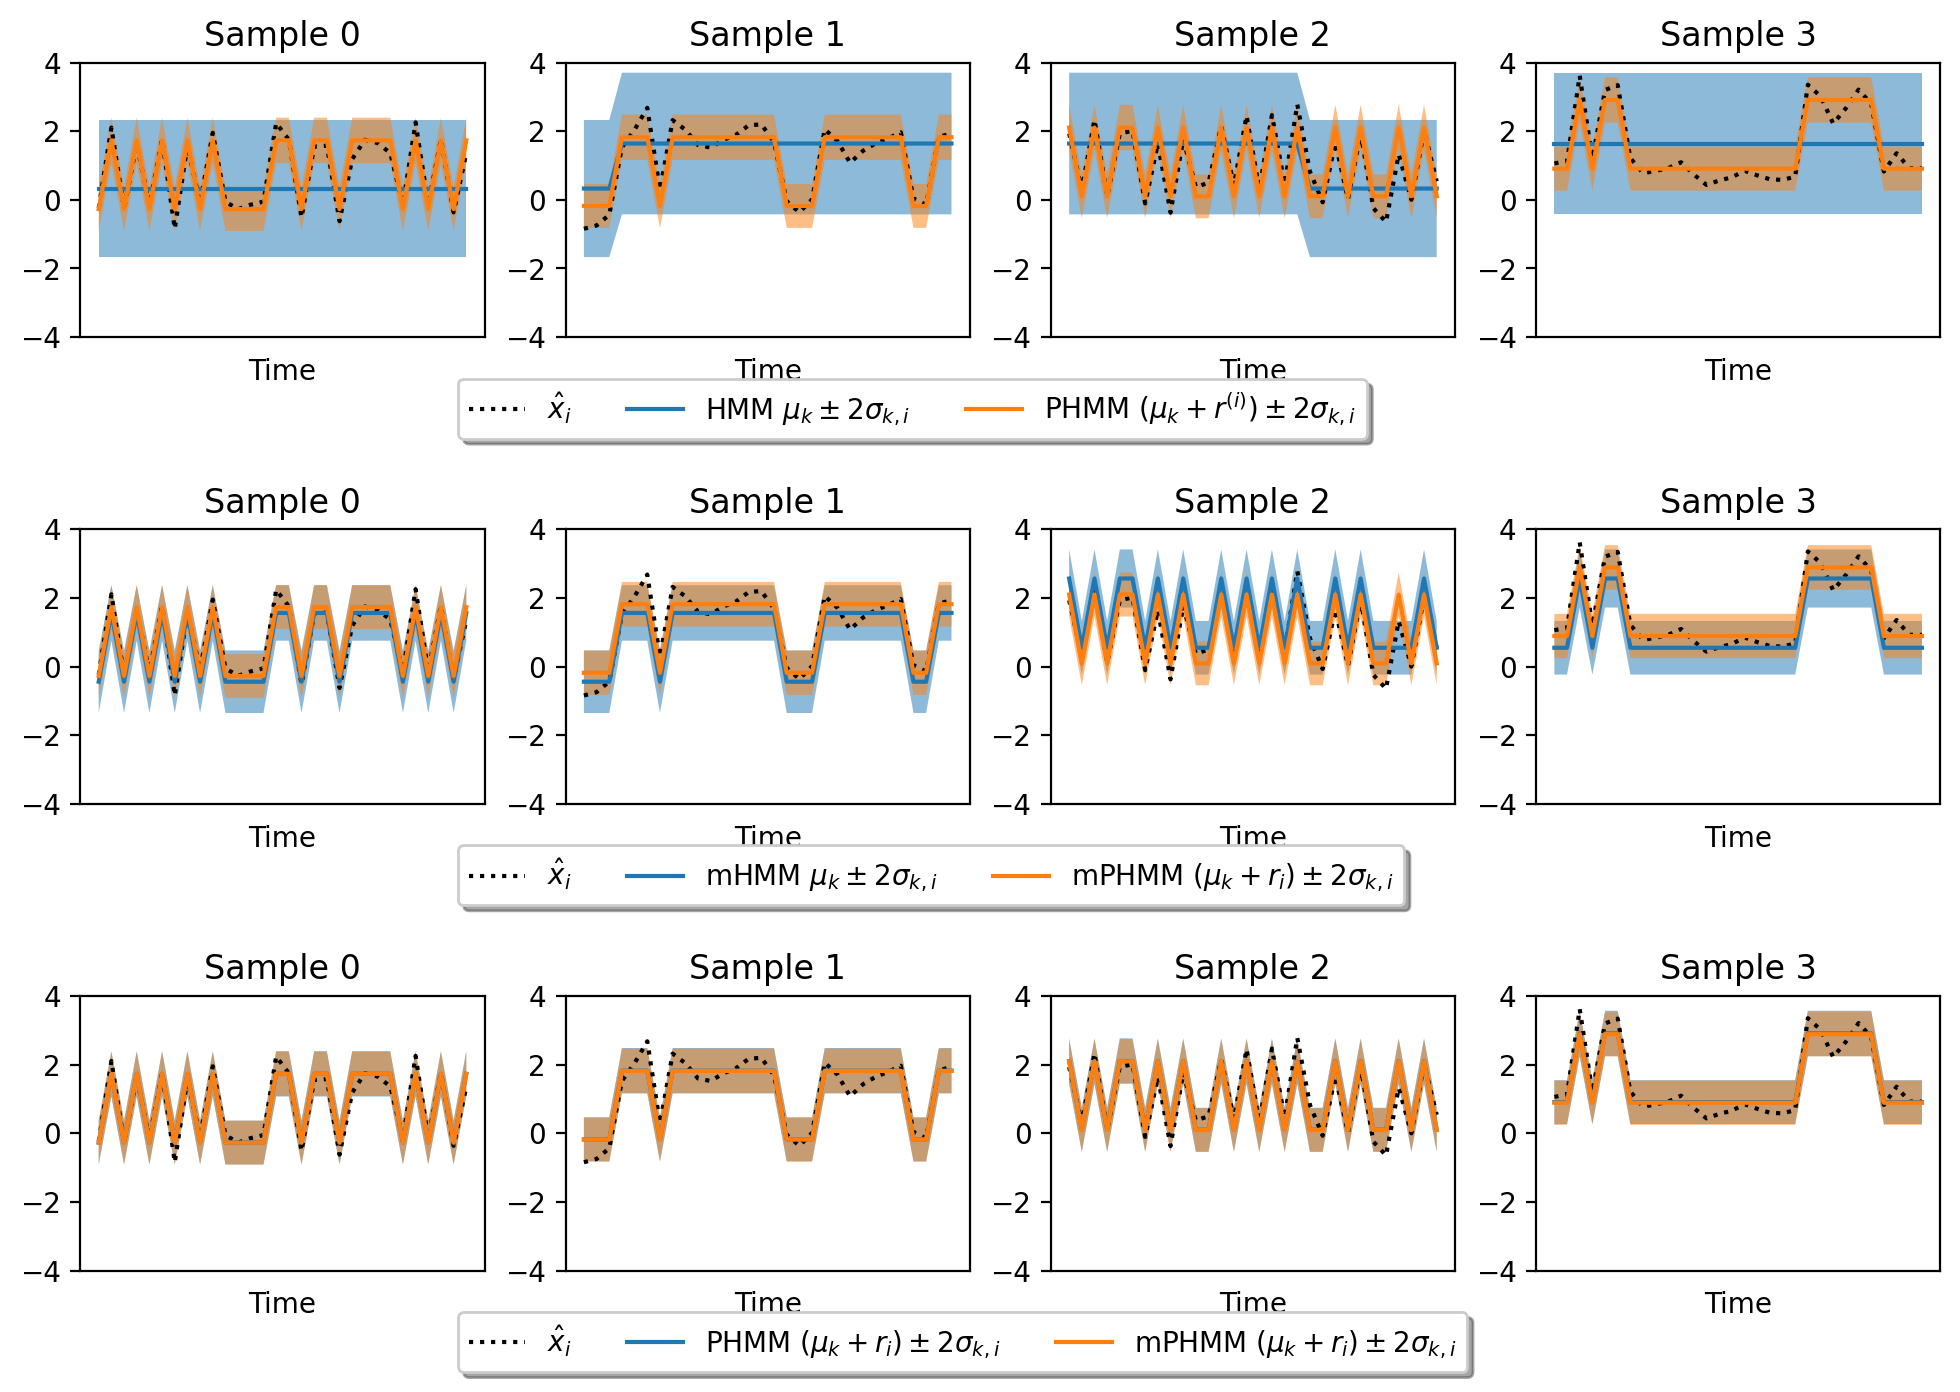

In [20]:
fig, axs = plt.subplots(3,4,dpi=200)
fig.set_size_inches(12,8)

for j in range(3):
    for i in range(4):
        ax = axs[j][i]
        ax.plot(X_hat[i, :].numpy(), 'k:', label='$\hat{x}_i$')
    
        if j == 0:
            xhat = preds["HMM"]["xhat"]
            xvar = preds["HMM"]["xvar"]
            ax.plot(xhat[i, :], label='HMM $\mu_k \pm 2\sigma_{k,i}$')
            ax.fill_between(np.arange(t), xhat[i,:] - xvar[i, :], xhat[i, :] + xvar[i, :], alpha=0.5)
            
            xhat = preds["PHMM"]["xhat"]
            xvar = preds["PHMM"]["xvar"]    
            ax.plot(xhat[i, :], label='PHMM $(\mu_k + r^{(i)}) \pm 2\sigma_{k,i}$')
            ax.fill_between(np.arange(t), xhat[i,:] - xvar[i, :], xhat[i, :] + xvar[i, :], alpha=0.5)
        elif j == 1:
            xhat = preds["mHMM"]["xhat"]
            xvar = preds["mHMM"]["xvar"]
            ax.plot(xhat[i, :], label='mHMM $\mu_k \pm 2\sigma_{k,i}$')
            ax.fill_between(np.arange(t), xhat[i,:] - xvar[i, :], xhat[i, :] + xvar[i, :], alpha=0.5)
            
            xhat = preds["mPHMM"]["xhat"]
            xvar = preds["mPHMM"]["xvar"]
            ax.plot(xhat[i, :], label='mPHMM $(\mu_k + r_i) \pm 2\sigma_{k,i}$')
            ax.fill_between(np.arange(t), xhat[i,:] - xvar[i, :], xhat[i, :] + xvar[i, :], alpha=0.5)
        else:
            xhat = preds["PHMM"]["xhat"]
            xvar = preds["PHMM"]["xvar"]    
            ax.plot(xhat[i, :], label='PHMM $(\mu_k + r_i) \pm 2\sigma_{k,i}$')
            ax.fill_between(np.arange(t), xhat[i,:] - xvar[i, :], xhat[i, :] + xvar[i, :], alpha=0.5)
            
            xhat = preds["mPHMM"]["xhat"]
            xvar = preds["mPHMM"]["xvar"]
            ax.plot(xhat[i, :], label='mPHMM $(\mu_k + r_i) \pm 2\sigma_{k,i}$')
            ax.fill_between(np.arange(t), xhat[i,:] - xvar[i, :], xhat[i, :] + xvar[i, :], alpha=0.5)            
    
        ax.set_xlabel("Time")
        ax.set_xticks([])
        ax.set_xticklabels([])        
        ax.set_title('Sample ' + str(i))
        ax.set_ylim([-4, 4])
    ax.legend(loc='lower left',bbox_to_anchor=(-2.7, -0.42), fancybox=True, shadow=True, ncol=4)
    
fig.tight_layout()  
fig.subplots_adjust(hspace=0.7)    
fig.savefig(
        "../outputs/synthetic_x_hats.png",
        dpi=400,
        facecolor="w",
        edgecolor="w",
        orientation="portrait",
        bbox_inches="tight",
        pad_inches=0,
        metadata={"Creator": None, "Producer": None, "CreationDate": None},
    )